# **Philippines Flower Image Classification**

In [32]:
import os
import uuid
import cv2
import splitfolders
import random
import shutil
import json
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.applications.resnet import ResNet50

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
def rename_files_in_directory(directory):

    for class_folder in os.listdir(directory):
        class_folder_path = os.path.join(directory, class_folder)
        
        if os.path.isdir(class_folder_path):
            files = os.listdir(class_folder_path)
            
            for idx, file_name in enumerate(files):
                file_path = os.path.join(class_folder_path, file_name)
               
                if not os.path.isfile(file_path):
                    continue
                
                file_extension = os.path.splitext(file_name)[1]
                
                new_name = f"{uuid.uuid4().hex}{file_extension}"
                new_file_path = os.path.join(class_folder_path, new_name)
                
                os.rename(file_path, new_file_path)

def delete_existing_splitfolders(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)

In [ ]:
base_flower = r'Img/Flowers'

with tarfile.open('flowers_image.tar.gz', "r:gz") as tar:
    tar.extractall(path='Img/Flowers')
    print(f"Extracted flowers_image.tar.gz to Img/Flowers")

Extracted flowers_image.tar.gz to Img/Flowers


In [4]:
rename_files_in_directory(base_flower)

In [5]:
count = []
dirs = os.listdir(base_flower)
for dir in dirs:
    files = list(os.listdir('Img/Flowers/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' Images')
    count.append(len(files))
print( f'Images Folder has {sum(count)} Images')
print( f'Mean count {np.mean(count)}')

Allamanda Folder has 120 Images
Bagawak-Morado Folder has 67 Images
Bauhinia Folder has 88 Images
Bird of Paradise Folder has 102 Images
Bougainvillea Folder has 136 Images
Dama de Noche Folder has 137 Images
Dona Aurora Folder has 50 Images
Fire Tree Flowers Folder has 113 Images
Gumamela Folder has 78 Images
Hoya Folder has 143 Images
Ilang-Ilang Folder has 113 Images
Kalachuchi Folder has 65 Images
Katmon Folder has 97 Images
Katuray Folder has 100 Images
Mimosa Folder has 91 Images
Palawan Cherry Folder has 95 Images
Pasiflora Folder has 122 Images
Rafflesia Folder has 100 Images
Rosal Folder has 68 Images
Sampaguita Folder has 92 Images
Santan Folder has 80 Images
Tuberose Folder has 71 Images
Waling-Waling Folder has 99 Images
White Angel Folder has 47 Images
Yellow Bell Folder has 102 Images
Images Folder has 2376 Images
Mean count 95.04


In [6]:
delete_existing_splitfolders('Img/Recognition')

In [7]:
input_folder = base_flower
output_folder = 'Img/Recognition'

split_ratio = (0.7, 0.15, 0.15)

splitfolders.ratio(input_folder, output=output_folder, seed=500, ratio=split_ratio, group_prefix=None)

train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

def check_and_remove_corrupt_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Check if the image can be opened
            except (OSError, IOError):
                print(f"Corrupted image file found and removed: {file_path}")
                os.remove(file_path)


check_and_remove_corrupt_images(train_dir)
check_and_remove_corrupt_images(val_dir)
check_and_remove_corrupt_images(test_dir)

Copying files: 2376 files [00:08, 289.78 files/s]


In [8]:
img_size = (224,224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_data = valid_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 1653 images belonging to 25 classes.
Found 377 images belonging to 25 classes.
Found 346 images belonging to 25 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


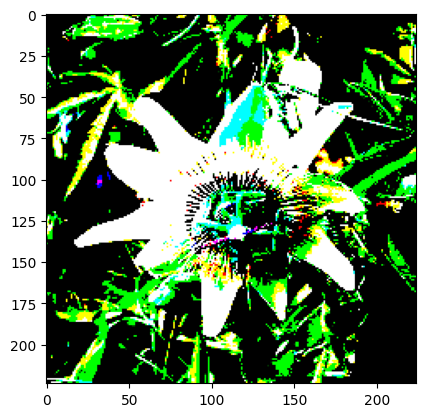

In [10]:
images, labels = next(valid_data)
idx = random.randint(0, images.shape[0] - 1)

plt.imshow(images[idx])
plt.show()

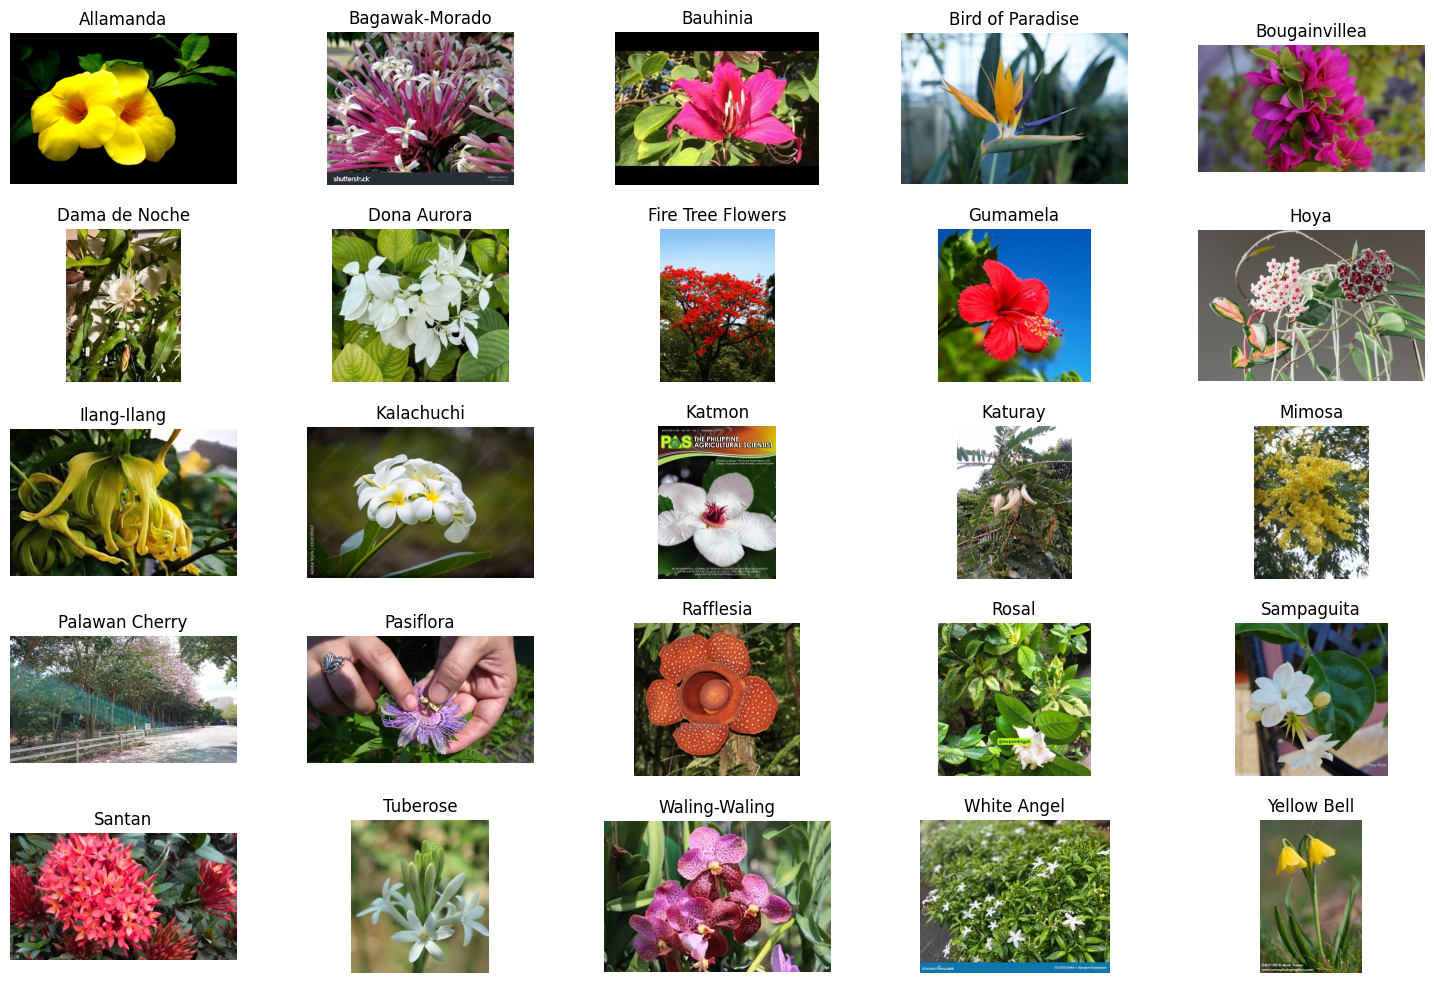

In [23]:
class_names = os.listdir(train_dir)
num_classes = len(class_names)

img_path_to_test = []
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
fig.tight_layout()

for idx, class_name in enumerate(class_names):
    class_folder = os.path.join(train_dir, class_name)

    image_files = os.listdir(class_folder)
    if not image_files:
        print(f"Warning: No images found in folder '{class_name}'. Skipping...")
        continue
    
    image_file = random.choice(image_files)
    image_path = os.path.join(class_folder, image_file)
    
    img_path_to_test.append(image_path)
    image = Image.open(image_path)
    row, col = divmod(idx, cols)
    axes[row, col].imshow(image)
    axes[row, col].axis("off")
    axes[row, col].set_title(class_name)

for idx in range(num_classes, rows * cols):
    row, col = divmod(idx, cols)
    axes[row, col].axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..151.061].


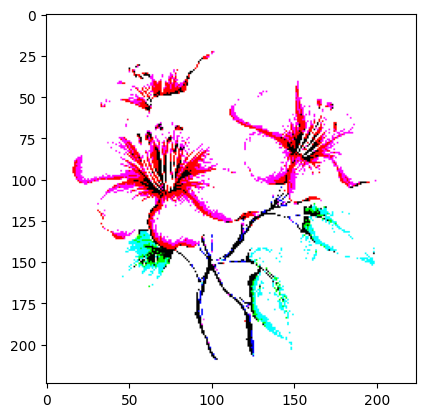

In [12]:
images, labels = next(valid_data)
idx = random.randint(0, images.shape[0] - 1)

plt.imshow(images[idx])
plt.show()

In [13]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_model.trainable = False

In [14]:
model = Sequential([
    base_model, 
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),  
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)), 
    layers.Dropout(0.4),  
    layers.Dense(25, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,156,569 (92.15 MB)

 Trainable params: 564,761 (2.15 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch % 7 == 0 and epoch != 0:
        return lr * 0.7 
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    train_data,
    epochs=25,  
    validation_data=valid_data,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

c:\Users\ikiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1777 - loss: 3.8764

c:\Users\ikiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.1794 - loss: 3.8665 - val_accuracy: 0.6272 - val_loss: 2.2386 - learning_rate: 0.0010
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5182 - loss: 2.3529 - val_accuracy: 0.7428 - val_loss: 1.7293 - learning_rate: 0.0010
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6233 - loss: 1.9101 - val_accuracy: 0.8006 - val_loss: 1.4402 - learning_rate: 0.0010
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6819 - loss: 1.7771 - val_accuracy: 0.8526 - val_loss: 1.2380 - learning_rate: 0.0010
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7274 - loss: 1.5677 - val_accuracy: 0.8584 - val_loss: 1.2289 - learning_rate: 0.0010
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7521 - loss: 1.4903 - val_accuracy: 0.8555 - val_loss: 1.2080 - learning_rate: 0.0010
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8022 - loss: 1.3265 - val_accuracy: 0.8786 -

In [17]:
def predict_image (image, model):
    print(image)
    test_img = cv2.imread(image)
    test_img = cv2.resize(test_img, (224,224))
    test_img = np.expand_dims(test_img, axis=0)
    result = model.predict(test_img)
    r = np.argmax(result)
    return flower_list[r]

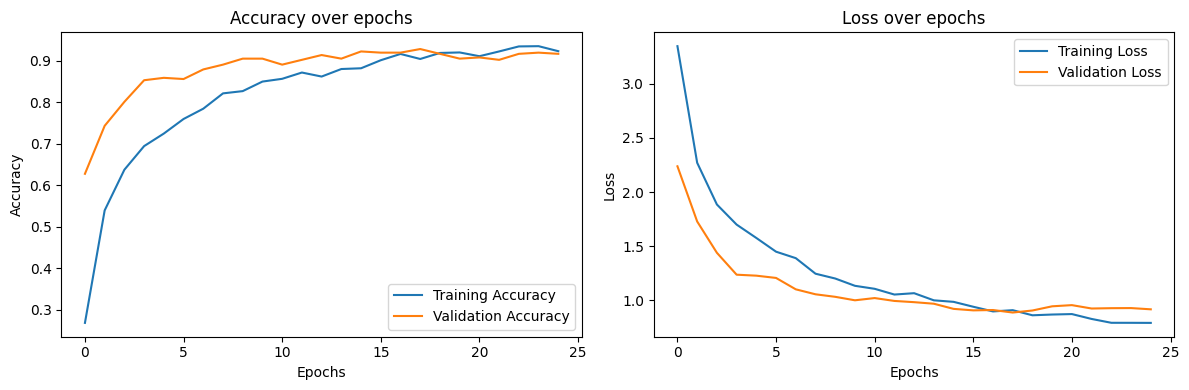

In [18]:
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history)

In [19]:
test_less, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9120 - loss: 0.9470
Test Accuracy: 91.51%


In [20]:
model.save('PHFlowers.keras')

In [24]:
y = 0
n = 0
for img_test in img_path_to_test:
    img_flower_class = img_test.split('\\')

    data_predict = predict_image(img_test, model)
    if data_predict['name'] == img_flower_class[2]:
        y += 1
    else:
        n += 1

Img/Recognition\train\Allamanda\b695f1dce0764630a2e7dff749e2a54a.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Img/Recognition\train\Bagawak-Morado\b7923901805d4472b5094465c6083256.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Img/Recognition\train\Bauhinia\14acdd8c9b524d36946c59885365b2a4.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Img/Recognition\train\Bird of Paradise\12dd1eb7f4c94025acc8f357adb4cb01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Img/Recognition\train\Bougainvillea\90806f92d74c426d8cc0211b417fc481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Img/Recognition\train\Dama de Noche\e712fdee9e284be382394229c5e3526c.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Img/Recognition\train\Dona Aurora\bff5833dfe1e47788bd528d9e2eed85a.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Img/Recognition\train\Fire Tree Flowers\85fb26b8ad1341ed80701f7c18e860d3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Img/Recognition\train\Gumamela\f8c68849e0e044c5b0e8c2e3c3dcb7ae.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Img/Re

In [25]:
print(f"Number of predicted right: {y}")
print(f"Number of predicted wrong: {n}")

print(f"Estimated Accuracy: {y / (y + n) * 100}")

Number of predicted right: 23
Number of predicted wrong: 2
Estimated Accuracy: 92.0
